Deck quality analyzer (by Arseny Khakhalin). 

Forked from the general analysis script. This script assumes that the "Basic analysis" notebook was already run, and so both "basic_data" and "distances" CSV files are already saved.

In [1]:
import pandas as pd
import numpy as np

import csv
import json

import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import time

from sklearn.manifold import MDS

In [2]:
from draftsim_utils_ab import *

# A set of useful utils: fixName(name), getName(card), isLegendary(card), getCardColor(card)
# where 'card' is a line in mtgJSON

Change the set abbrevation below to work with a different set:

In [3]:
# Alternatives: XLN, DOM, M19, GRN, RNA
setName = 'GRN'

In [4]:
#mtgJSON = json.load(open('Allsets.json'))
with open('../../data/Allsets.json', 'r',encoding='utf-8') as json_data:
    mtgJSON = json.load(json_data)
    
jsonSubset = mtgJSON[setName]['cards']

if setName=='XLN':
    jsonSubset = jsonSubset+ mtgJSON['RIX']['cards']

In [5]:
thisSet = {getName(card) : card for card in jsonSubset} # dict with names as indices for cards, for all cards in set
dict((k.lower(), v) for k, v in thisSet.items())        # Lowercase the keys
cardlist = list(thisSet.keys())                         # List of card names (strings)

# thisSet[list(thisSet.keys())[0]] # Full info for one card

Change the addresses below if you store data ini a different folder locally:

In [6]:
dataFileNames = {
    'XLN': '../2018-02-23 Two days data XLN.csv',
    'DOM': '../2018-04-16 Dominiaria initial data-2.csv',
    'M19': '../2018-08-23 m19 drafts round 2.csv',
    'GRN': '../2018-10-05 GRN Draft Data 1.csv',
    'RNA': '../2019-01-22 RNA merged.csv'
}

draftData = pd.read_csv('../'+dataFileNames[setName], 
                       names = ['format', 'human', 'bot1', 'bot2', 'bot3', 'bot4', 'bot5', 'bot6', 'bot7'])

# draftData.head()
print('Loaded ', len(draftData['format']), " draft records.")

Loaded  118792  draft records.


In [7]:
# Read basic set data and card-to-card distances

df = pd.read_csv('basic_data_'+setName+'.csv')
df = df.set_index('name')

dist = np.genfromtxt('distances_'+setName+'.csv', delimiter=',')

df = df.loc[df.freq>0] # Remove cards that are formally in the set, but are actually never drafted

In [8]:
# Create a new df with a more inclusive color allocation (multis are counted as all colors)

df2 = df.copy()
colorLines = pd.DataFrame(
    { 'w': ['W' in thisSet[cardName]['colorIdentity'] for cardName in df2.index],
      'u': ['U' in thisSet[cardName]['colorIdentity'] for cardName in df2.index],
      'b': ['B' in thisSet[cardName]['colorIdentity'] for cardName in df2.index],
      'r': ['R' in thisSet[cardName]['colorIdentity'] for cardName in df2.index],
      'g': ['G' in thisSet[cardName]['colorIdentity'] for cardName in df2.index]},
             list(df2.index))
df2 = df2.join(colorLines)
#df2

In [9]:
# A tiny function that turns azorius_guildgate_2 to azorius_guildgate.
# Both df and carslist don't have these _2 cards, and so they aren't in the dist as well.
# Not sure why this error didn't come up earlier.

def fix_gates(cardName):
    if cardName[-2]=='_':
        return cardName[:-2]
    else:
        return cardName

In [10]:
# Constants for the main cycle below (no need to change them)

colorList = ['w','u','b','r','g']
guildNames = {'wu':'Azo','uw':'Azo','wb':'Orz','bw':'Orz','wr':'Bor','rw':'Bor','wg':'Sel','gw':'Sel',
              'ub':'Dim','bu':'Dim','ur':'Izz','ru':'Izz','ug':'Sim','gu':'Sim',
              'br':'Rak','rb':'Rak','bg':'Gol','gb':'Gol',
              'rg':'Gru','gr':'Gru'}


In [56]:
# ----------------------
# Main loop (goes through hands and calculates their stats)
# ----------------------

playerName = 'human' # <------------------- Either 'human' or 'bot1' (or any other bot for this matter)
maxDeckNumber = 5000 # <------------------ How many decks to use (set a real high number if you want all of them)
targetHandSize = 25 # How many cards to pick from the pile. Set to 0 to disable. Keep close to 45 to only trim worst cards.

sumPick = [0]*maxDeckNumber # Sum of pick numbers (higher = worse)
sumDist = [0]*maxDeckNumber # Sum of distances from other cards (higher = worse)
draftCount = 0
guilds = [] # Code from a list

for pile in draftData[playerName][0:maxDeckNumber]:
    pile = fixName(pile).lower().split(',')
    
    # Pick a deck from the pile
    if targetHandSize==0:
        hand = pile
    else:
        hand = []
        for icard in range(targetHandSize):
            if icard==0:
                # First card is special: find the seed that is least distant from all other cards
                synergy = [0]*len(pile)
                for jcard in range(len(pile)):
                    for kcard in range(len(pile)):
                        if kcard!=jcard:
                            synergy[jcard] += dist[cardlist.index(fix_gates(pile[jcard]))]\
                                                  [cardlist.index(fix_gates(pile[kcard]))]
                ind = np.argmin(synergy)
                hand.append(pile[ind])
                pile.pop(ind)
            else: # All other cards
                synergy = [0]*len(pile)
                for jcard in range(len(pile)):
                    for kcard in range(len(hand)):
                        synergy[jcard] += dist[cardlist.index(fix_gates(pile[jcard]))]\
                                              [cardlist.index(fix_gates(hand[kcard]))]
                ind = np.argmin(synergy)
                hand.append(pile[ind])
                pile.pop(ind)
    
    for icard in range(len(hand)):
        sumPick[draftCount] += df.loc[fix_gates(hand[icard])]['avg']
        for jcard in range(icard):
            sumDist[draftCount] += dist[cardlist.index(fix_gates(hand[jcard]))][cardlist.index(fix_gates(hand[icard]))]
    draftCount += 1
    
    colorCount = [0]*5
    for icolor in range(len(colorList)):
        colorCount[icolor] = sum(df2.loc[hand][colorList[icolor]]) 
        # Here hand is a list, it selects from df2, then we pick proper column according to code from colorList ('w' etc.)

    color1 = np.argmax(colorCount) # Most common color in this pile (excluding multicolors, which is suboptimal)
    colorCount[color1] = 0
    color2 = np.argmax(colorCount)

    guilds.append(guildNames[colorList[color1]+colorList[color2]])

In [58]:
# Make a data frame:

dataToPlot = pd.DataFrame({'ind': pd.Series(range(len(sumPick))), 'sumPick': sumPick, 'sumDist': sumDist, 'guild': guilds})

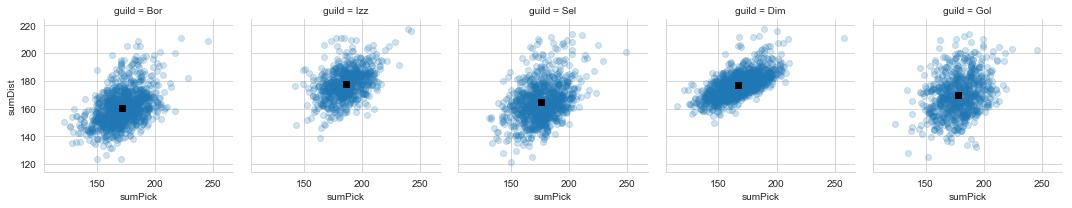

In [59]:
# Plot everything:

#myPal = sns.xkcd_palette(["gold","deep blue","black","red","green","lavender","grey"])

sns.set_style("whitegrid")
g = sns.FacetGrid(dataToPlot, col="guild", col_wrap = 5, aspect = 1)
s = g.map(plt.scatter,"sumPick","sumDist",alpha=0.2)#,palette=myPal)
#s.fig.set_size_inches(7,6)
#s.despine(left=True,bottom=True)
#s.set(xticklabels=[],yticklabels=[],xlabel='',ylabel='');

def mean_point(x,y, **kwargs):
    plt.plot(x.mean(), y.mean(),'ks')
    #plt.text(x.mean()+1, 0.052, 'mean = '+str('%.2f'%x.mean()), size=12)
    #plt.text(x.mean()+1, 0.0455, 'std = '+str('%.2f'%x.std()), size=12)

g.map(mean_point, 'sumPick' , 'sumDist');

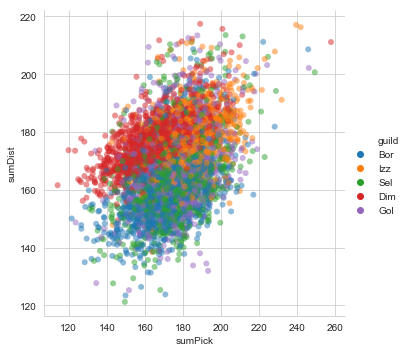

In [60]:
# All in one plot

sns.set_style("whitegrid")
s = sns.relplot(data=dataToPlot, x='sumPick', y='sumDist', hue='guild',
                alpha=0.5, edgecolor='none')

# Not very helpful because of colors, and it's hard to come up with good colors here.
# Also the sequence of guilds is arbitrary (the order in which they were met in the data), which doesn't help coloring them.

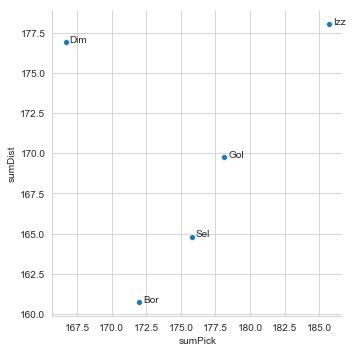

In [61]:
sumData = dataToPlot.groupby('guild').mean()

p1 = sns.relplot(data=sumData, x='sumPick', y='sumDist')

for iline in range(0,sumData.shape[0]):
    p1.axes[0,0].text(sumData['sumPick'][iline]+0.3, sumData['sumDist'][iline], sumData.index.values.tolist()[iline])

In [62]:
# Short helper function to better visualize hands

def showHand(hand):
    hand = fixName(hand).lower().split(',')
    return pd.DataFrame({'color': [''.join(thisSet[card]['colorIdentity']) for card in list(hand)],
                         'rank' : [df.loc[fix_gates(card)]['avg'] for card in list(hand)]},
                        list(hand))

# Oddly ''.join() works like a charm: ''.join(thisSet[hand[0]]['colorIdentity'])

       ind     sumPick     sumDist guild
3669  3669  139.812935  166.644590   Bor
670    670  216.984133  158.316175   Bor
753    753  180.722720  137.855842   Bor
2150  2150  162.669150  198.992943   Bor


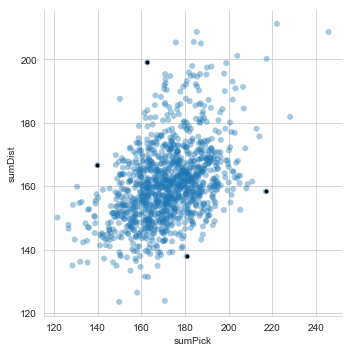

conclave_tribunal, healer's_hawk, boros_challenger, wojek_bodyguard, healer's_hawk, sworn_companions, boros_guildgate, darkblade_agent, blade_instructor, divine_visitation, blade_instructor, house_guildmage, dimir_locket, bartizan_bats, disinformation_campaign, collar_the_culprit, swiftblade_vindicator, conclave_tribunal, collar_the_culprit, necrotic_wound, cosmotronic_wave, sworn_companions, hammer_dropper, spinal_centipede, rosemane_centaur, mephitic_vapors, house_guildmage, moodmark_painter, never_happened, vicious_rumors, gatekeeper_gargoyle, skyline_scout, inspiring_unicorn, boros_challenger, boros_guildgate, necrotic_wound, dead_weight, arboretum_elemental, hammer_dropper, dead_weight, urban_utopia, parhelion_patrol, grappling_sundew, urban_utopia, vicious_rumors
                        color       rank
conclave_tribunal           W   1.114830
healer's_hawk               W   4.274521
boros_challenger           RW   4.103828
wojek_bodyguard             R   7.107667
healer's_hawk  

In [65]:
# Look at some extreme decks (worst, best, etc)

%matplotlib inline

localData = dataToPlot.loc[dataToPlot['guild']=='Bor']

# Find some interesting points, with neutral values on one axis, and extreme values of another
indLeft   = localData.index[localData['sumPick']==min(localData['sumPick'][localData['sumDist']>np.median(localData['sumDist'])])][0]
indRight  = localData.index[localData['sumPick']==max(localData['sumPick'][localData['sumDist']<np.median(localData['sumDist'])])][0]
indBottom = localData.index[localData['sumDist']==min(localData['sumDist'][localData['sumPick']>np.median(localData['sumPick'])])][0]
indTop    = localData.index[localData['sumDist']==max(localData['sumDist'][localData['sumPick']<np.median(localData['sumPick'])])][0]

extremePointsInd = [indLeft, indRight, indBottom, indTop]

print(localData.loc[extremePointsInd])

sns.relplot(data=localData, x='sumPick', y='sumDist', edgecolor='none', alpha=0.4);
plt.plot(localData.loc[extremePointsInd]['sumPick'],localData.loc[extremePointsInd]['sumDist'],'k.')
plt.show() # For the plot to stay above the text

# Look at any of these 4 extreme decks. First as a simple list:
print(fixName(draftData[playerName].iloc[indLeft]).replace(",",", "))

# Then as an annoted column of data:
print(showHand(draftData[playerName].iloc[indLeft]))


### Next steps:

First priority:

* ~~Sensitivity: same, but for bot drafts~~
* ~~Compare bots to humans directly?~~
* ~~GRN~~
* ~~Look at individual decks at extremes: best deck, wost, most synergistic, most bomby~~
* ~~Run same analysis, but after selecting 25 best cards from each pile (ignore the off-strategy picks)~~

Second priority:

* Put in perspective: add random decks and "ideal decks" on the same plot

Third priority:

* Simple Bot (fixed synergy / rating ratio across draft), % of match with humans
* Simple Bot, % of match with Dan bots (current draftsim)
* Compare average bot-drafted deck across guilds


In [29]:
# Direct comparison of bots to humans
#
# I am ashamed to confess that this module only works if you first run everything above for humans, 
# run this cell, then run everything for bots, and run this cell again. Then run next cell.

if playerName=='human':
    humanData = dataToPlot.copy()
    print('Human rewritten, bot preserved')
else:
    botData = dataToPlot.copy()
    print('Bot rewritten, human preserved')

Bot rewritten, human preserved


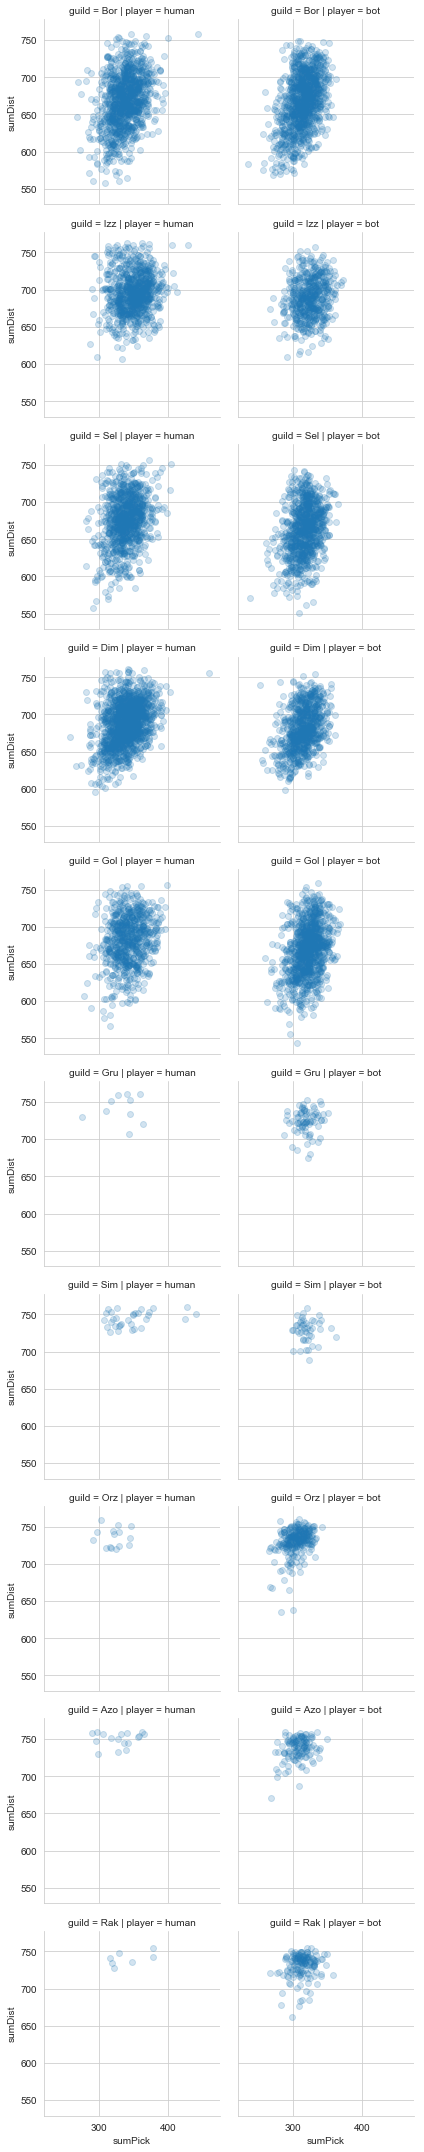

In [30]:
# Combine human and bot data and plot them.
    
tempH = humanData
tempH['player'] = 'human'

tempB = botData
tempB['player'] = 'bot'

fullSet = pd.concat([tempH,tempB],axis=0)

#fullSet['player'].unique()

sns.set_style("whitegrid")
g = sns.FacetGrid(fullSet, col="player", row="guild", aspect = 1)
s = g.map(plt.scatter,"sumPick","sumDist",alpha=0.2)#,palette=myPal)

